## Data and Package Importing

In [1]:
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80, frameon=False)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['ml_utils']
from ml_utils import *

### Load data and preprocess

In [2]:
%time s1 = sc.read_h5ad('../data/2771-AS-3-ACAGTG_S3.h5ad')

CPU times: user 5.89 s, sys: 951 ms, total: 6.84 s
Wall time: 6.89 s


In [3]:
s1

AnnData object with n_obs × n_vars = 14189 × 38459 
    obs: 'ken_filter'

In [4]:
# checkpoint raw data for future filtering
s1.raw = s1

In [5]:
%%time
# quick reordering of AnnData object, since our inflection point analysis assumes that libraries are sorted from highest to lowest quality
reorder_adata(s1)

# create new "observations" as percent and mean mito genes
s1.var['mito'] = s1.var_names.str.contains('mt-') # identify mitochondrial genes
s1.obs['mean_mito'] = np.mean(s1[:,s1.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(s1, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var

# rank cells by total counts and save as .obs
s1.obs['ranked_total_counts'] = np.argsort(s1.obs['total_counts'])

CPU times: user 5.25 s, sys: 1.45 s, total: 6.69 s
Wall time: 6.69 s


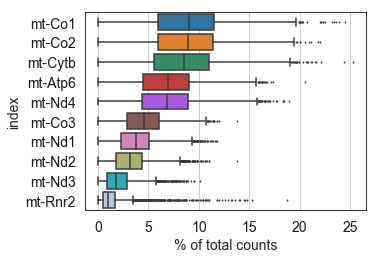

In [6]:
# look at highest expression by gene across all cells
sc.pl.highest_expr_genes(s1, n_top=10)

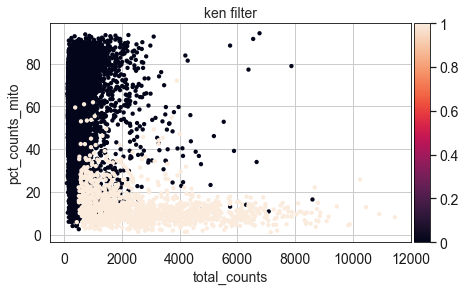

In [7]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Find inflection point

Inflection point at index
bcHJQA     2991
bcDRKD     4649
bcAYYP     6704
bcHERT     9046
bcEJNL    11567
bcDAWR    12864
bcGJGH    14188
Name: total_counts, dtype: int64 for [0, 20, 40, 60, 80, 90, 100] percentiles of greatest secant distances


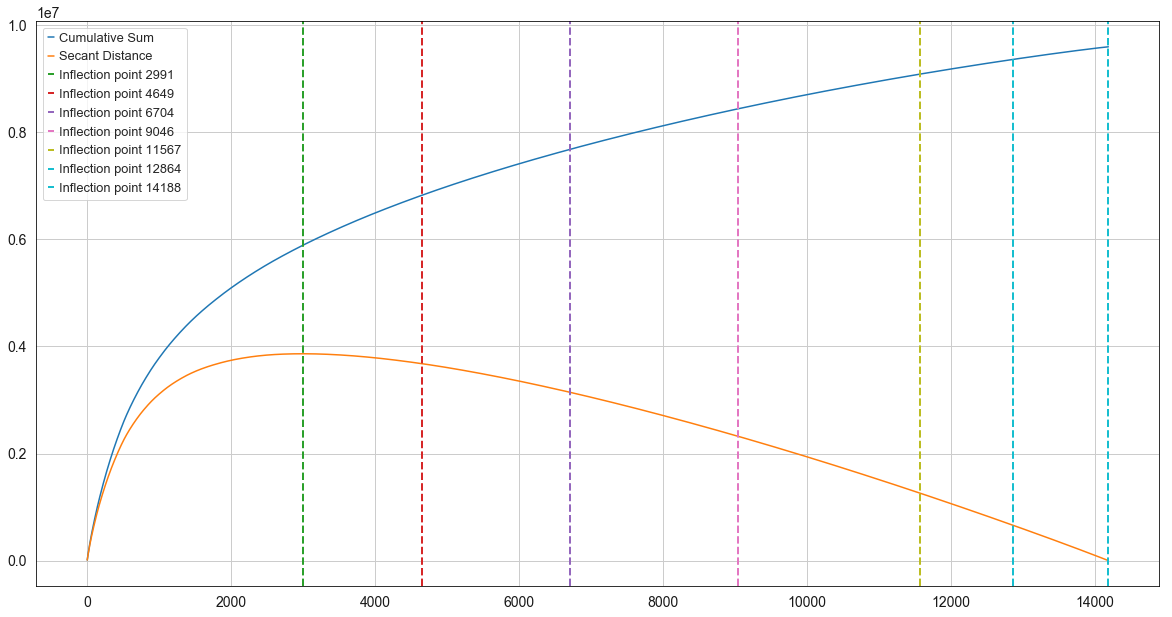

In [8]:
find_inflection(s1, inflection_percentiles = [0,20,40,60,80,90,100])

In [9]:
s1.obs['total_counts'][12864] # see the total counts for the cutoff point

198.0

In [10]:
# create new "observation" as empty droplet label
s1.obs['bagging_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][12864], 1, 0) # 1 is "empty", 0 is __initially__ "not empty"

In [11]:
s1.obs['bagging_empty'].value_counts()

0    12848
1     1341
Name: bagging_empty, dtype: int64

In [12]:
# create new "observation" as empty droplet label
s1.obs['twostep_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][12864], 1, -1) # 1 is empty, -1 is unlabeled
s1.obs.loc[s1.obs['ranked_total_counts']>=s1.n_obs*0.98, 'twostep_empty'] = 0 # take top 2% of dataset by total UMI counts and add as "not empty"

In [13]:
s1.obs['twostep_empty'].value_counts()

-1    12565
 1     1341
 0      283
Name: twostep_empty, dtype: int64

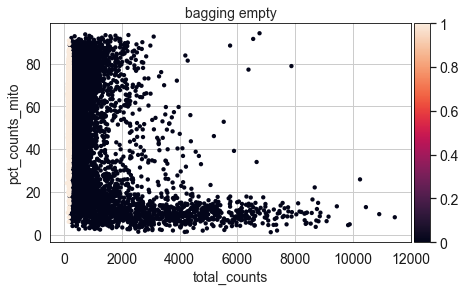

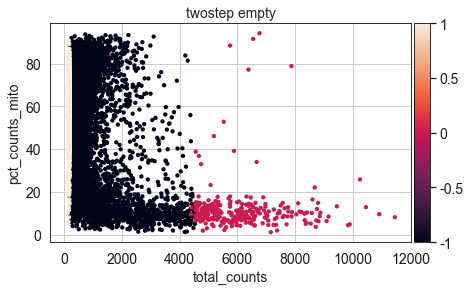

In [14]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_empty', size=75)
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_empty', size=75)

### Normalize and perform linear dimensionality reduction with PCA

In [15]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 3.31 s, sys: 512 ms, total: 3.82 s
Wall time: 3.83 s


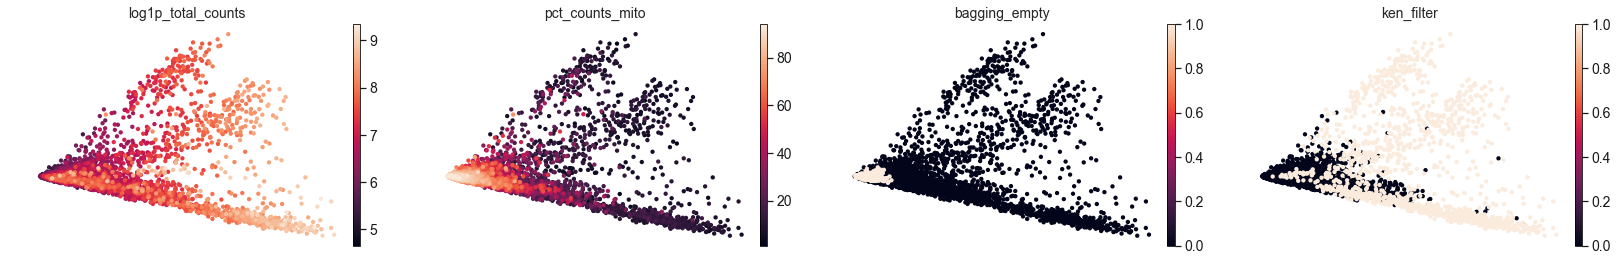

CPU times: user 1min 19s, sys: 4.16 s, total: 1min 23s
Wall time: 15.8 s


In [16]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','bagging_empty','ken_filter'], ncols=4, size=75)

---
### TwoStep

In [17]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['twostep_empty'].copy(deep=True) # training labels are from .obs df

In [18]:
%%time
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # define random forest classifier, you can plug in any classifier though!
scores_twostep_empty, labels_twostep_empty = twoStep(clf=rf, X=X, y=y, n_iter=18)

Step 1 labeled 5100 new positives and 169 new negatives.
Iteration 1: Doing step 2... Step 1 labeled 551 new positives and 85 new negatives.
Iteration 2: Doing step 2... Step 1 labeled 159 new positives and 57 new negatives.
Iteration 3: Doing step 2... Step 1 labeled 107 new positives and 20 new negatives.
Iteration 4: Doing step 2... Step 1 labeled 41 new positives and 30 new negatives.
Iteration 5: Doing step 2... Step 1 labeled 42 new positives and 44 new negatives.
Iteration 6: Doing step 2... Step 1 labeled 25 new positives and 22 new negatives.
Iteration 7: Doing step 2... Step 1 labeled 28 new positives and 33 new negatives.
Iteration 8: Doing step 2... Step 1 labeled 26 new positives and 25 new negatives.
Iteration 9: Doing step 2... Step 1 labeled 24 new positives and 42 new negatives.
Iteration 10: Doing step 2... Step 1 labeled 18 new positives and 29 new negatives.
Iteration 11: Doing step 2... Step 1 labeled 13 new positives and 47 new negatives.
Iteration 12: Doing step 

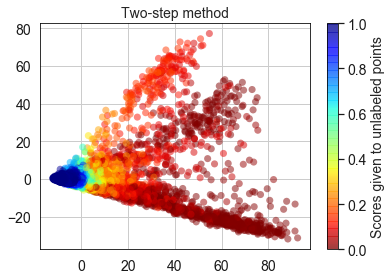

In [19]:
# visualize final TwoStep results
plt.scatter(
    X[:,0], X[:,1], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

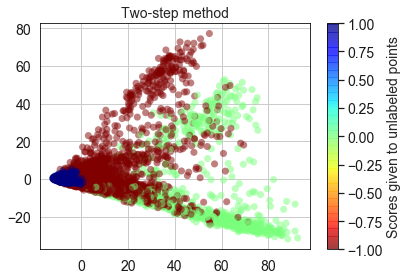

In [20]:
# visualize final TwoStep results
plt.scatter(
    X[:,0], X[:,1], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

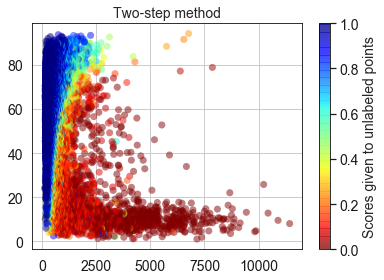

In [21]:
# visualize final TwoStep results
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = scores_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

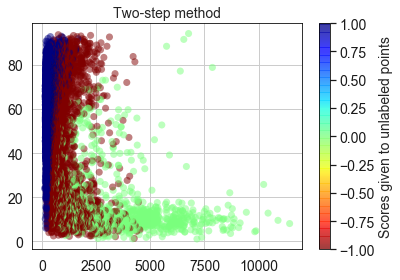

In [22]:
# visualize final TwoStep results
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = labels_twostep_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

In [28]:
s1.obs['twostep_result'] = np.where(scores_twostep_empty>=0.2, 1, 0)

In [24]:
s1.obs['ken_filter'].value_counts()

0    12886
1     1303
Name: ken_filter, dtype: int64

In [29]:
s1.obs['twostep_result'].value_counts()

1    12115
0     2074
Name: twostep_result, dtype: int64

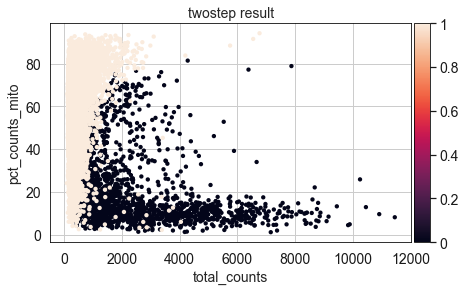

In [30]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='twostep_result', size=75)

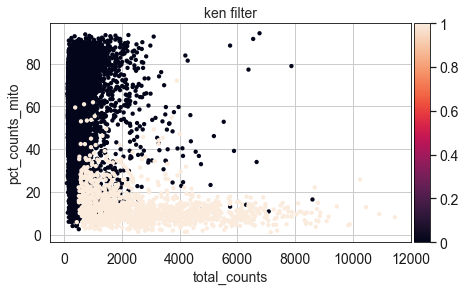

In [31]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [32]:
s1_notempty = s1[s1.obs['twostep_result']==0,:].copy() # move forward with non-empty droplets

In [33]:
s1_notempty.X = s1_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [34]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 504 ms, sys: 24.7 ms, total: 529 ms
Wall time: 529 ms


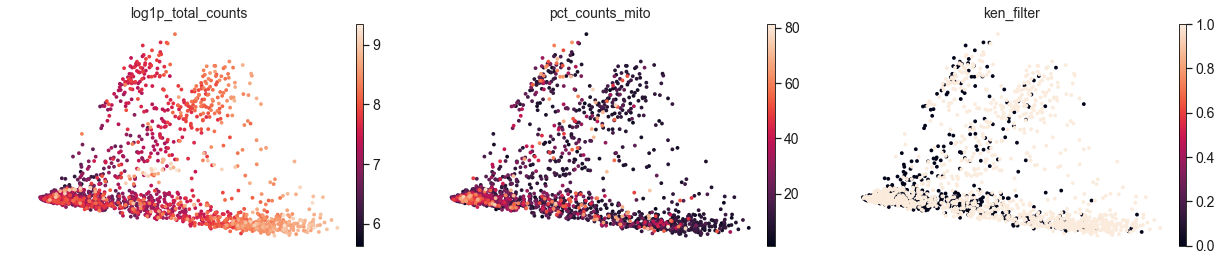

CPU times: user 19.7 s, sys: 2.12 s, total: 21.8 s
Wall time: 2.92 s


In [35]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

### Clustering

In [36]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_notempty, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 3.18 s, sys: 124 ms, total: 3.3 s
Wall time: 2.78 s


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


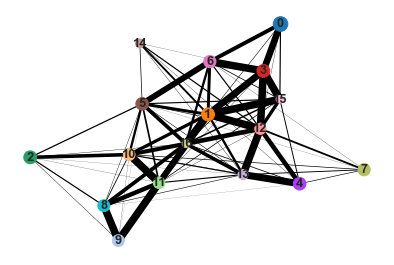

In [37]:
sc.tl.paga(s1_notempty) #perform PAGA
sc.pl.paga(s1_notempty)

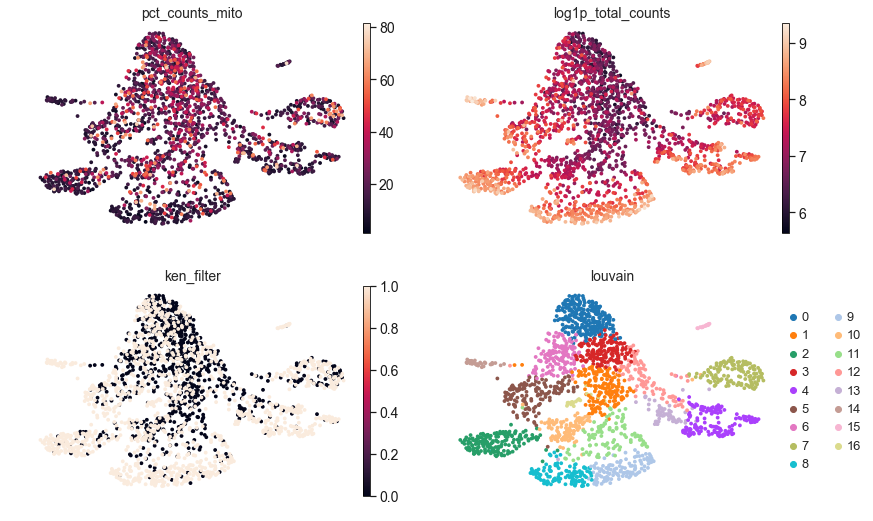

In [38]:
sc.tl.umap(s1_notempty, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_notempty))
sc.pl.umap(s1_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter','louvain'], ncols=2)

---
## Ken Filtering

In [39]:
s1_gold = s1[s1.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets

In [40]:
s1_gold.X = s1_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [41]:
%%time
sc.pp.normalize_total(s1_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_gold) # log1p transformation
sc.pp.scale(s1_gold, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 305 ms, sys: 11.3 ms, total: 316 ms
Wall time: 315 ms


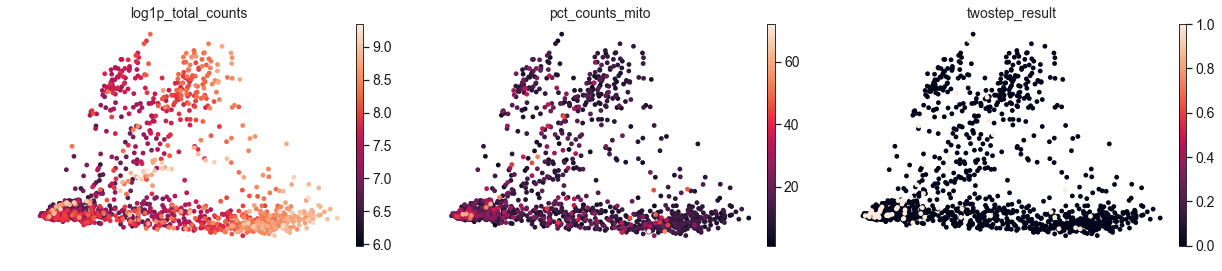

CPU times: user 15.4 s, sys: 2.33 s, total: 17.7 s
Wall time: 2.2 s


In [42]:
%%time
sc.tl.pca(s1_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_gold, color=['log1p_total_counts','pct_counts_mito','twostep_result'], ncols=3)

### Clustering

In [43]:
%%time
sc.pp.neighbors(s1_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(s1_gold, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

CPU times: user 559 ms, sys: 76.9 ms, total: 636 ms
Wall time: 180 ms


/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


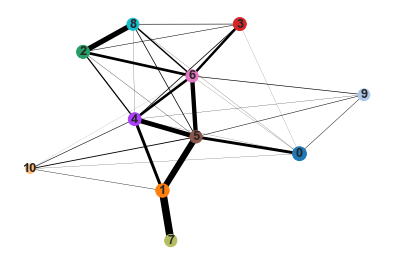

In [44]:
sc.tl.paga(s1_gold) #perform PAGA
sc.pl.paga(s1_gold)

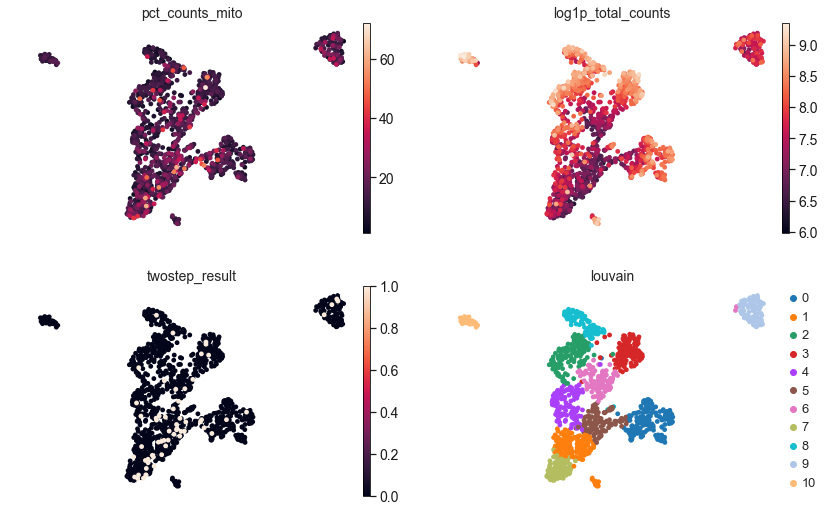

In [45]:
sc.tl.umap(s1_gold, init_pos=sc.tl._utils.get_init_pos_from_paga(s1_gold))
sc.pl.umap(s1_gold, color=['pct_counts_mito','log1p_total_counts','twostep_result','louvain'], ncols=2)

---
### PU Bagging

In [46]:
# define X and y for classifier training for simplicity
X = s1.obsm['X_pca'] # training data is PCA results
y = s1.obs['bagging_empty'].copy(deep=True) # training labels are from .obs df

In [ ]:
%%time

bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)

results_bagging_empty = bc.oob_decision_function_[:,1]

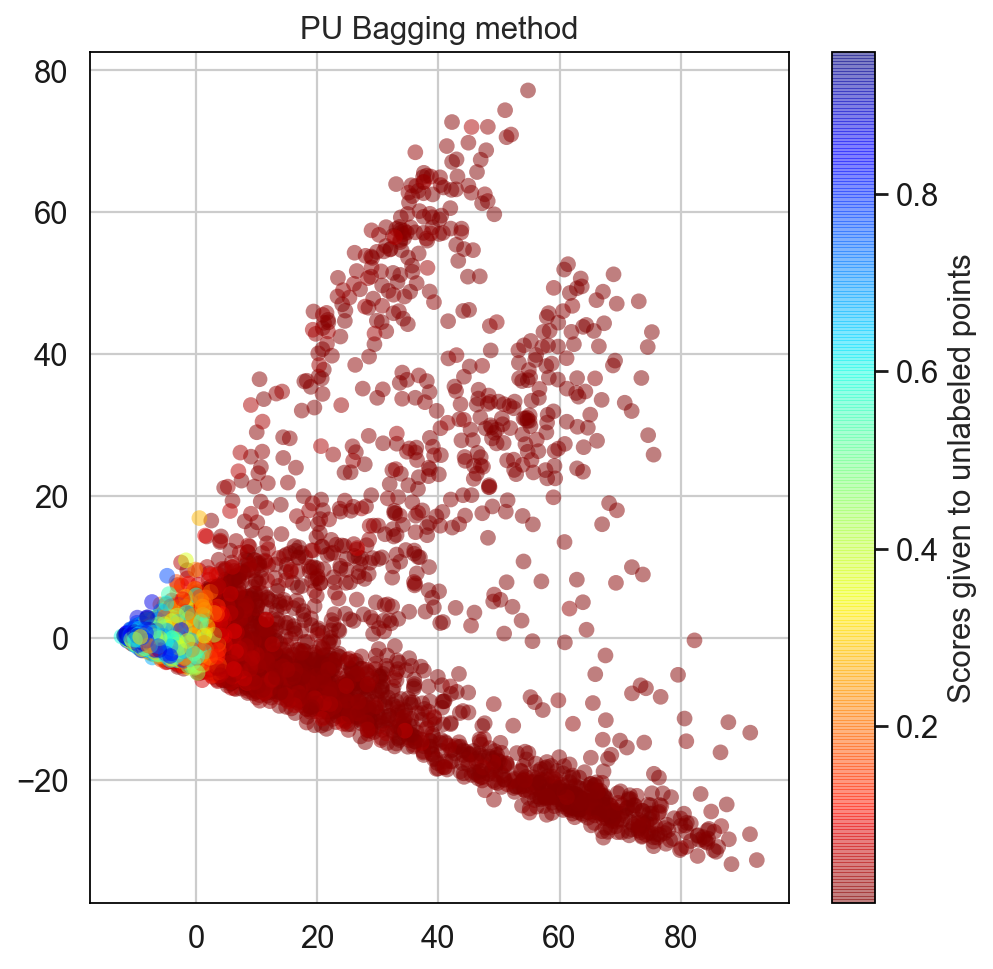

In [19]:
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

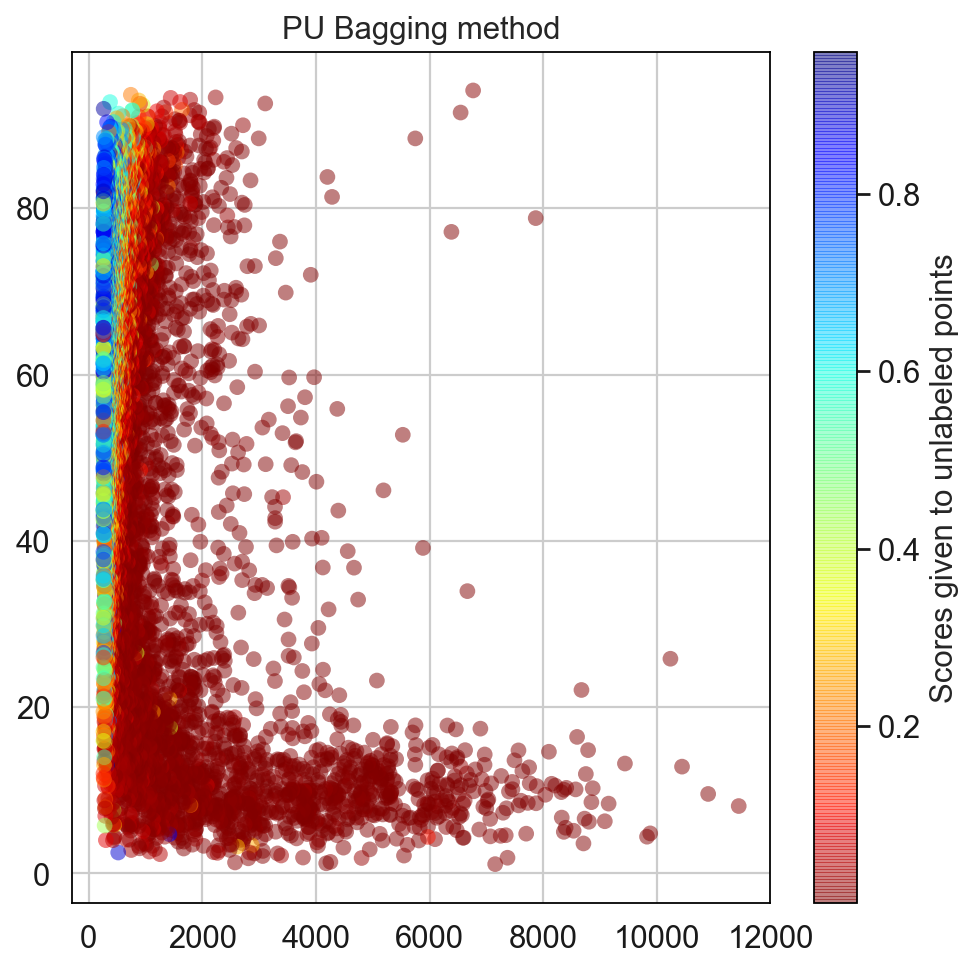

In [20]:
# visualize final TwoStep results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_empty, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging method')
plt.show()

In [25]:
s1.obs['bagging_result'] = np.where(results_bagging_empty>=0.2, 1, 0)

In [26]:
s1.obs['ken_filter'].value_counts()

0    12886
1     1303
Name: ken_filter, dtype: int64

In [27]:
s1.obs['bagging_result'].value_counts()

0    9533
1    4656
Name: bagging_result, dtype: int64

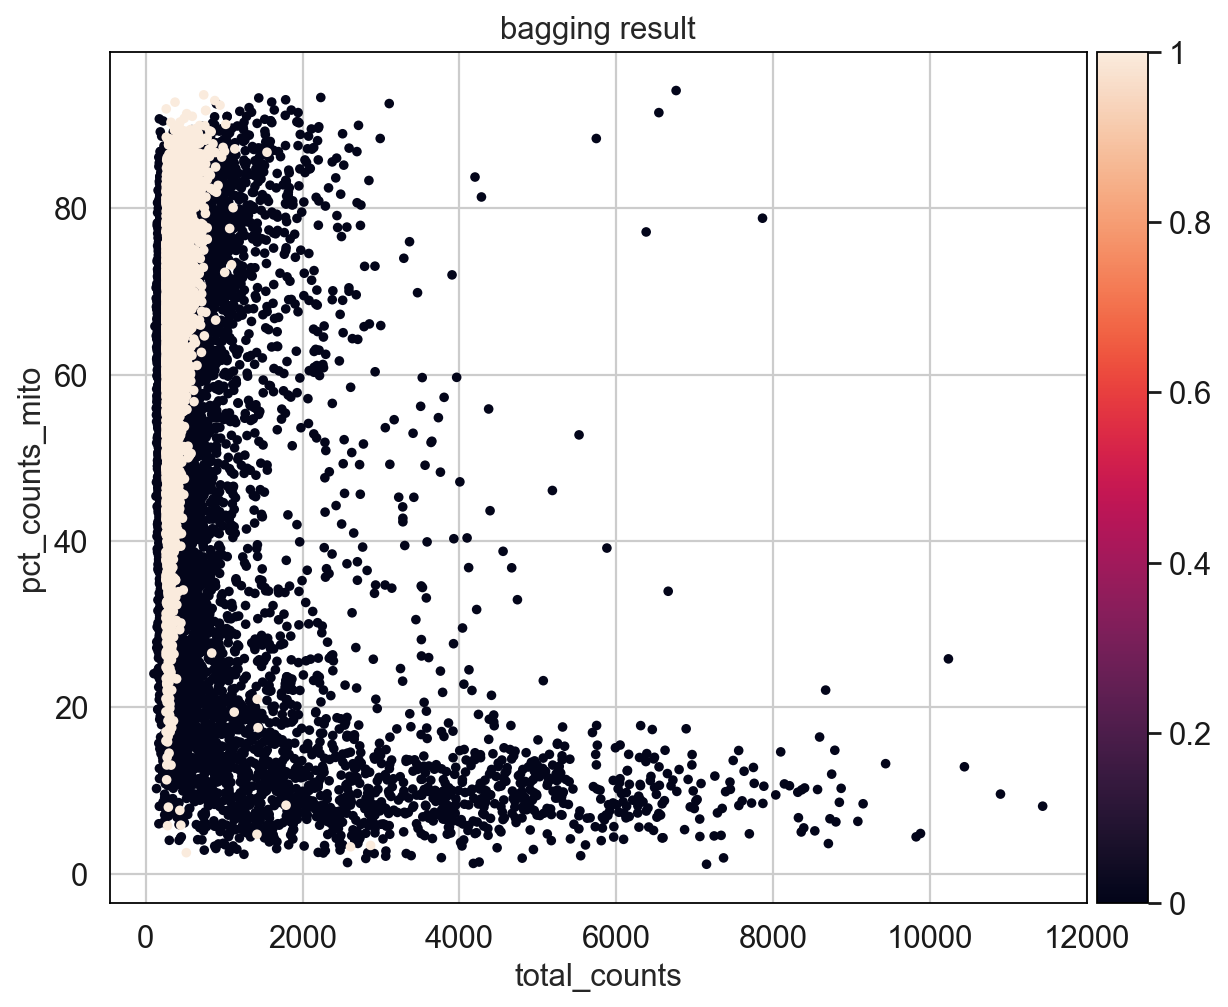

In [28]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='bagging_result', size=75)

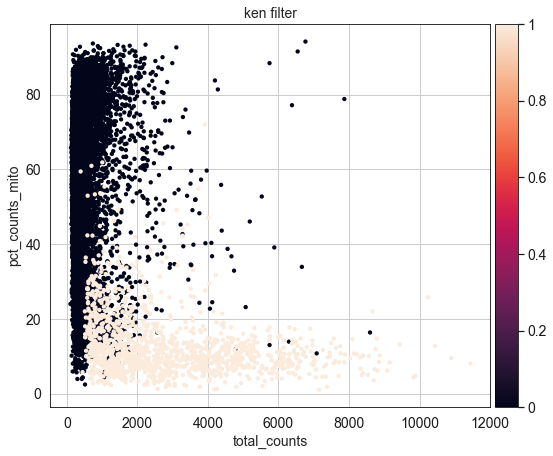

In [24]:
# look at low-quality and dead cell distribution with Ken's filtering
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

In [25]:
s1_notempty = s1[s1.obs['bagging_result']==0,:].copy() # move forward with non-empty droplets

In [26]:
s1_notempty.X = s1_notempty.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [27]:
%%time
sc.pp.normalize_total(s1_notempty, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_notempty) # log1p transformation
sc.pp.scale(s1_notempty, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 570 ms, sys: 38 ms, total: 608 ms
Wall time: 608 ms


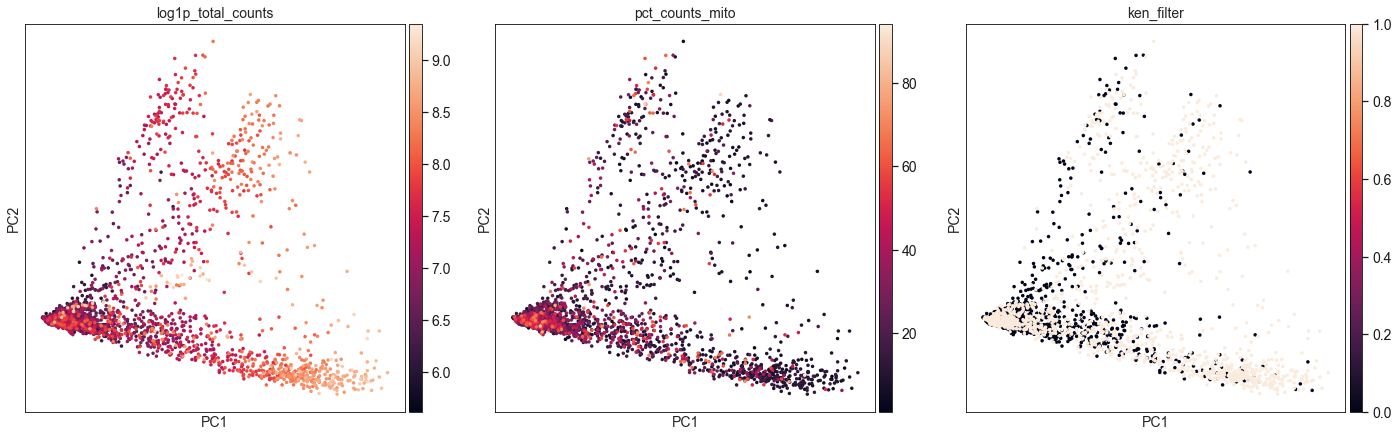

CPU times: user 21.3 s, sys: 2.35 s, total: 23.7 s
Wall time: 3.44 s


In [28]:
%%time
sc.tl.pca(s1_notempty, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_notempty, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=3)

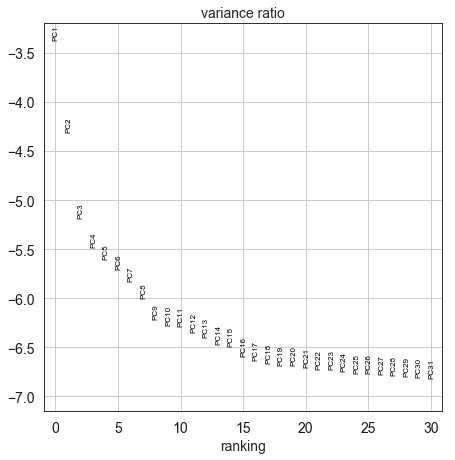

In [29]:
sc.pl.pca_variance_ratio(s1_notempty, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [30]:
%%time
sc.pp.neighbors(s1_notempty, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(s1_notempty, random_state=1) # perform UMAP

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compile

CPU times: user 8.5 s, sys: 226 ms, total: 8.73 s
Wall time: 7.57 s


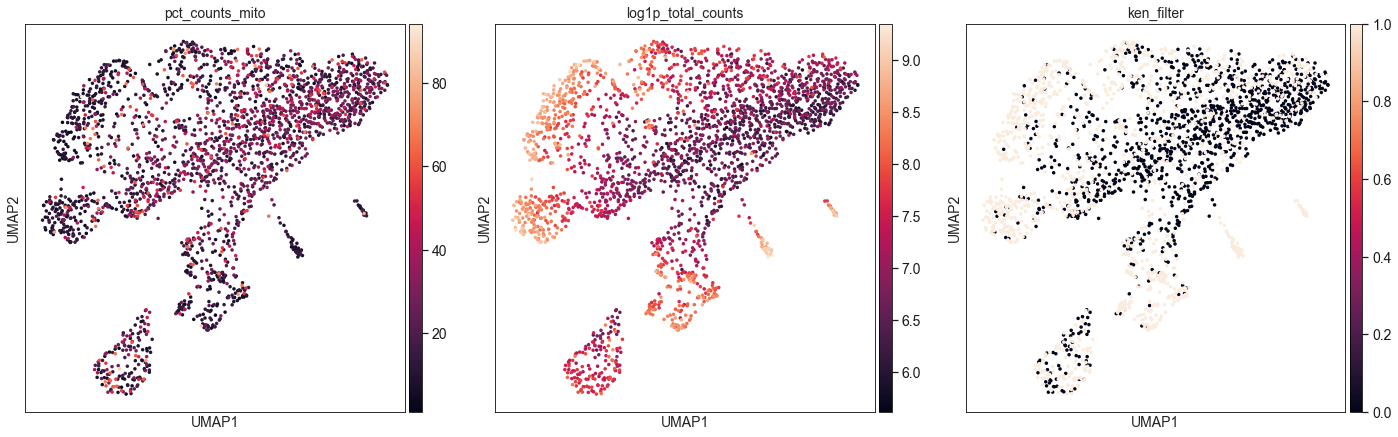

In [31]:
sc.pl.umap(s1_notempty, color=['pct_counts_mito','log1p_total_counts','ken_filter'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

### Clustering

In [32]:
sc.tl.louvain(s1_notempty, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

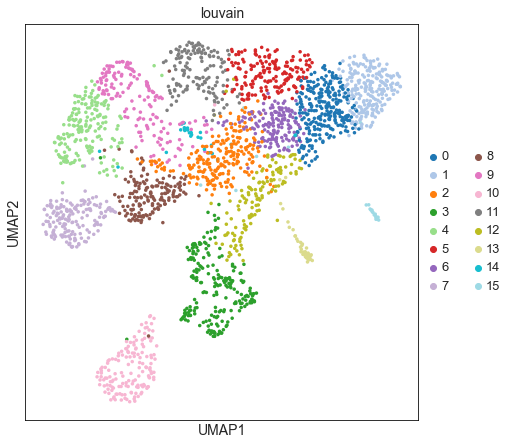

In [33]:
sc.pl.umap(s1_notempty, color=['louvain'], palette='tab20')

---
## Ken Filtering

In [34]:
s1_gold = s1[s1.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets

In [35]:
s1_gold.X = s1_gold.raw.X

### Normalize and perform linear dimensionality reduction with PCA

In [36]:
%%time
sc.pp.normalize_total(s1_gold, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1_gold) # log1p transformation
sc.pp.scale(s1_gold, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 303 ms, sys: 16 ms, total: 319 ms
Wall time: 319 ms


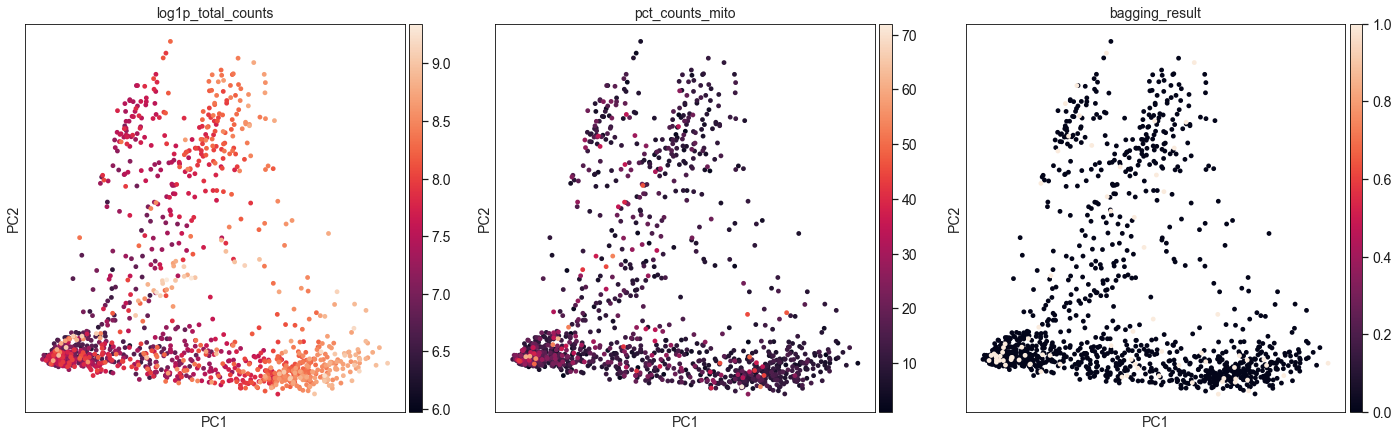

CPU times: user 15.7 s, sys: 2.05 s, total: 17.8 s
Wall time: 2.35 s


In [37]:
%%time
sc.tl.pca(s1_gold, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1_gold, color=['log1p_total_counts','pct_counts_mito','bagging_result'], ncols=3)

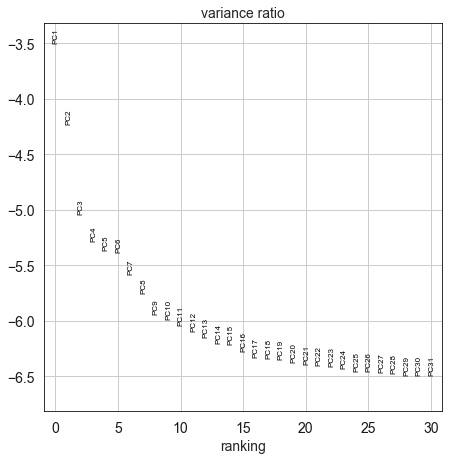

In [38]:
sc.pl.pca_variance_ratio(s1_gold, log=True) #examine amount of variance captured by each principal component

### Non-linear dimensionality reduction with UMAP

In [39]:
%%time
sc.pp.neighbors(s1_gold, n_neighbors=30, n_pcs=20, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.umap(s1_gold, random_state=1) # perform UMAP

CPU times: user 2.83 s, sys: 147 ms, total: 2.98 s
Wall time: 1.99 s


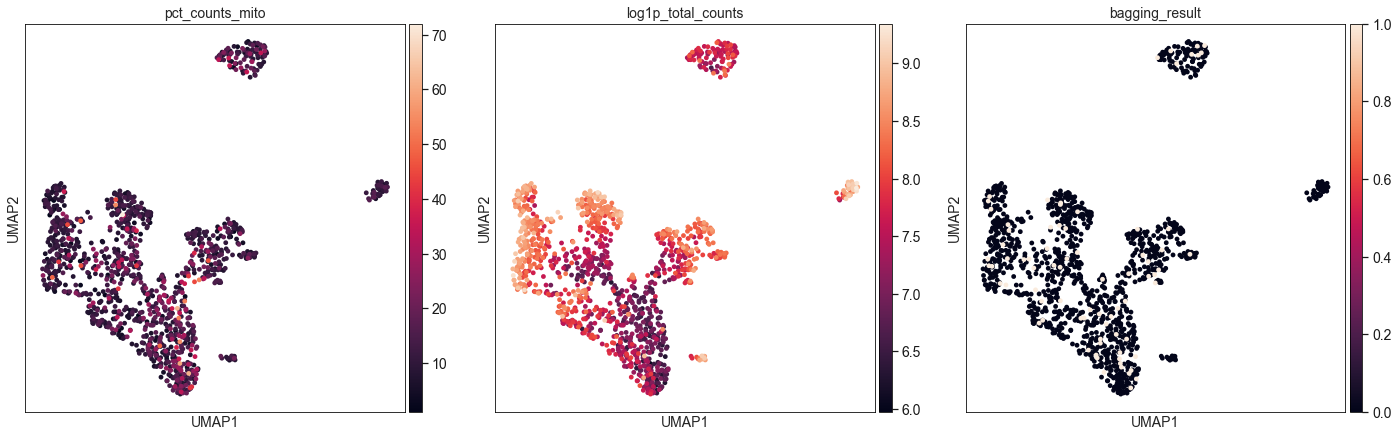

In [40]:
sc.pl.umap(s1_gold, color=['pct_counts_mito','log1p_total_counts','bagging_result'], ncols=3) # plot marker genes to determine which clusters to keep or gate out

### Clustering

In [41]:
sc.tl.louvain(s1_gold, resolution=1.8, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters

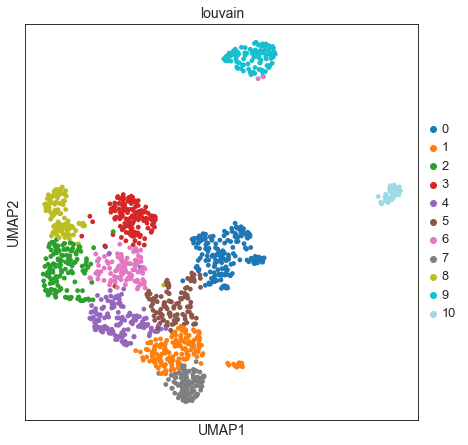

In [42]:
sc.pl.umap(s1_gold, color=['louvain'], palette='tab20')